In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import re
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
# Import label encoder
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
# Import label encoder
from sklearn import preprocessing
import gensim
from gensim.models import Word2Vec
from sklearn.metrics import f1_score
import string

In [2]:
#Words to lower case
def to_lower(text):
    return text.lower()

#Tagging words
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lemmatize docs
def lemmatizer(doc):
    lem = WordNetLemmatizer()
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return ' '.join([lem.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags])

#Wordcloud visualization
def visualize_WordCloud(df):

    business = df[df['CategoryID'] == 0]
    business = business['Text']

    scitech = df[df['CategoryID'] == 1]
    scitech = scitech['Text']

    sports = df[df['CategoryID'] == 2]
    sports = sports['Text']

    world = df[df['CategoryID'] == 3]
    world = world['Text']

    wordcloud = WordCloud(background_color='white', width=2500, height=2500).generate(' '.join(business))
    plt.figure(1, figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.title("Business Related Words:")
    plt.axis("off")
    plt.show()

    wordcloud = WordCloud(background_color='white', width=2500, height=2500).generate(' '.join(scitech))
    plt.figure(1, figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.title("Sci/Tech Related Words:")
    plt.axis("off")
    plt.show()

    wordcloud = WordCloud(background_color='white', width=2500, height=2500).generate(' '.join(sports))
    plt.figure(1, figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.title("Sports Related Words:")
    plt.axis("off")
    plt.show()

    wordcloud = WordCloud(background_color='white', width=2500, height=2500).generate(' '.join(world))
    plt.figure(1, figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.title("World Related Words:")
    plt.axis("off")
    plt.show()

#Cleaning texts
def cleanText(text):
    text = re.sub("\d+", " number ", text)  # change numbers to word " number "
    text = text.translate(text.maketrans("£.,;:\-/", "$       ", "!#%&'()*+<=>?@[]^_`{|}~"))  # replace £ with $ and remove punctuation

    text = re.sub("\s\s+" , " ", text)

    text = text.replace("$ number", "money")
    text = text.replace("number bn", "money")
    text = text.replace("money bn", "money")
    text = text.replace("money money", "money")
    text = text.replace("number number", "number")

    text = to_lower(text)

    # Stopword temizligi
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    text = [x for x in words if x not in stop_words]
    text = " ".join(text)

    text = lemmatizer(text)

    """    # Lematize islemi
        wordnet = WordNetLemmatizer()
        text = " ".join([wordnet.lemmatize(word) for word in text])"""

    """# --Stemming--
    stemmer = PorterStemmer()

    text = word_tokenize(text)
    text = ' '.join([stemmer.stem(word) for word in text])"""

    return text

#Removing the duplicate texts
def detectDuplication(df):
    print("Before Removal")
    print(f'Number of samples: {df.shape[0]}\nNumber of features: {df.shape[1]}')
    print("After Removal")
    df = df.drop_duplicates(subset=['Text'])
    print(f'Number of samples: {df.shape[0]}\nNumber of features: {df.shape[1]}\n')

    return df

def plot_cm(cm):
    df_cm = pd.DataFrame(cm, index=category.values(), columns=category.values())
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Target')

In [3]:
# Veri seti okunmasi
df = pd.read_csv('train_ilk.csv',sep=";")

df.head()

,Category,Text
0,Business,"Reuters - Short-sellers, Wall Street's dwindli..."
1,Business,Reuters - Private investment firm Carlyle Grou...
2,Business,Reuters - Soaring crude prices plus worries\ab...
3,Business,Reuters - Authorities have halted oil export\f...
4,Business,"AFP - Tearaway world oil prices, toppling reco..."


In [4]:
df.shape

(120000, 2)

In [5]:
df['Category'].value_counts()

Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: Category, dtype: int64

In [6]:
# Label encoder kullanılark kategorik degiskenler numeriklestirildi
print(df['Category'].unique())
label_encoder = preprocessing.LabelEncoder()

df['CategoryID'] = label_encoder.fit_transform(df['Category'])

df['CategoryID'].unique()
##########################################################################################################

['Business' 'Sci/Tech' 'Sports' 'World']


array([0, 1, 2, 3])

In [7]:
df.head()

,Category,Text,CategoryID
0,Business,"Reuters - Short-sellers, Wall Street's dwindli...",0
1,Business,Reuters - Private investment firm Carlyle Grou...,0
2,Business,Reuters - Soaring crude prices plus worries\ab...,0
3,Business,Reuters - Authorities have halted oil export\f...,0
4,Business,"AFP - Tearaway world oil prices, toppling reco...",0


In [8]:
# Integer ciktisina gore kategori eslestirmek icin üolan dict degiskeni olusturuldu.
category = df[["Category", "CategoryID"]].drop_duplicates().sort_values('CategoryID')
category = dict(category[['CategoryID', 'Category']].values)  # Category Dictionary

category
##########################################################################################################

{0: 'Business', 1: 'Sci/Tech', 2: 'Sports', 3: 'World'}

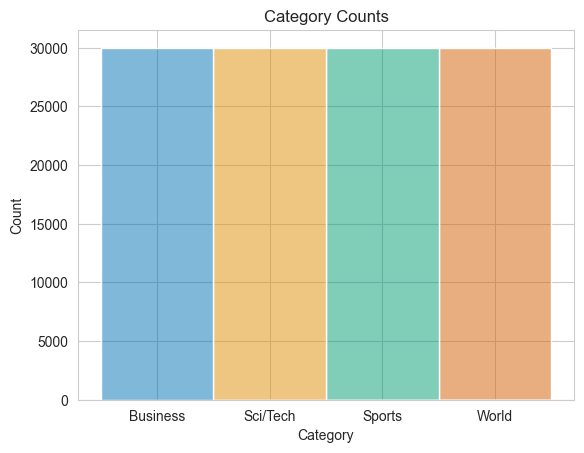

In [9]:
# Histogram Cizimi
ax2 = sns.histplot(
    data=df,
    x='Category',
    hue='Category',
    palette='colorblind',
    legend=False,
).set(
    title='Category Counts');

plt.show()

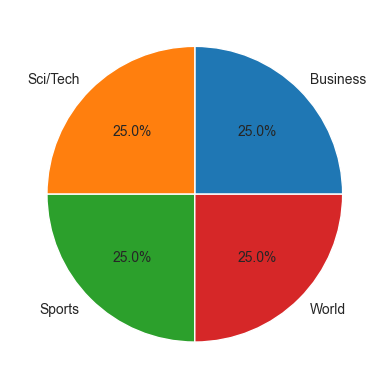

In [10]:
# Pasta Grafigi Cizimi
plt.pie(df['Category'].value_counts(), labels=category.values(),
        autopct='%1.1f%%')
plt.show()
##########################################################################################################

In [11]:
# Veri seti bilgilendirme
print(f'----Train----\nNumber of samples: {df.shape[0]}\nNumber of features: {df.shape[1]}')
##########################################################################################################

----Train----
Number of samples: 120000
Number of features: 3


In [12]:
#Tekrarlanan verilerin temizlenmesi
print("Train set duplication detection:\n")
df = detectDuplication(df)

Train set duplication detection:

Before Removal
Number of samples: 120000
Number of features: 3
After Removal
Number of samples: 120000
Number of features: 3



In [13]:
print("Temizlik Öncesi:\n")
print(df['Text'][0])
print("\n"+df['Text'][26])

# Veri Temizligi
df['Text'] = df['Text'].apply(cleanText)
##########################################################################################################

print("\nTemizlik Sonrası:\n")
print(df['Text'][0])
print("\n"+df['Text'][26])

Temizlik Öncesi:

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.Wall St. Bears Claw Back Into the Black (Reuters)

An auction of shares in Google, the web search engine which could be floated for as much as \$36bn, takes place on Friday.Google auction begins on Friday

Temizlik Sonrası:

reuters short seller wall street dwindle band ultra cynic see green wall st bear claw back black reuters

auction share google web search engine could float much money take place friday google auction begin friday


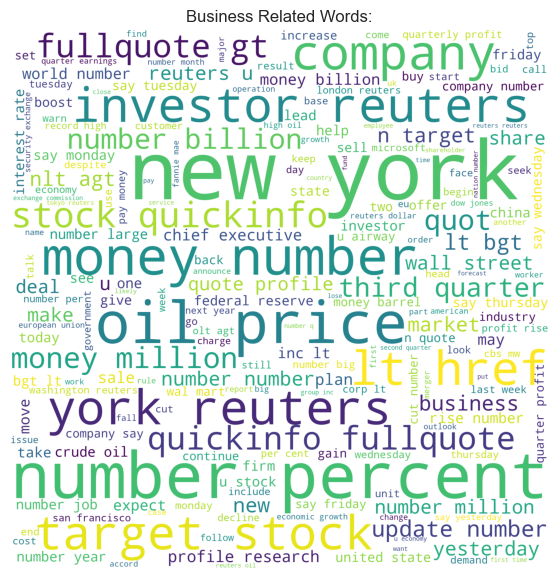

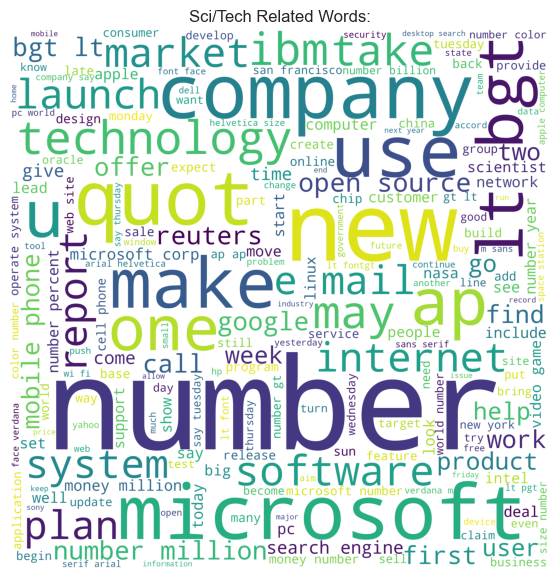

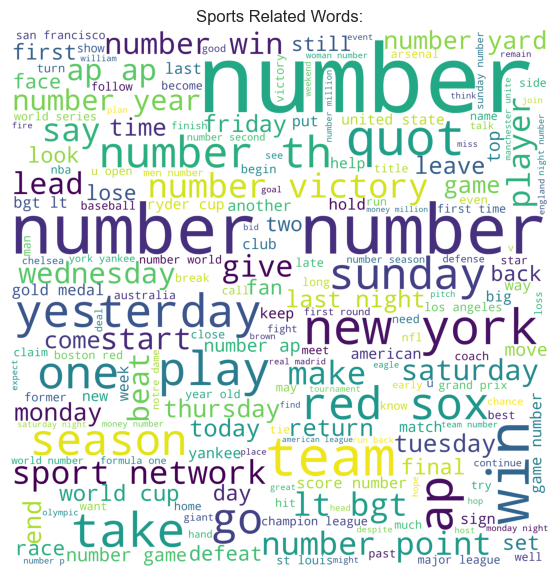

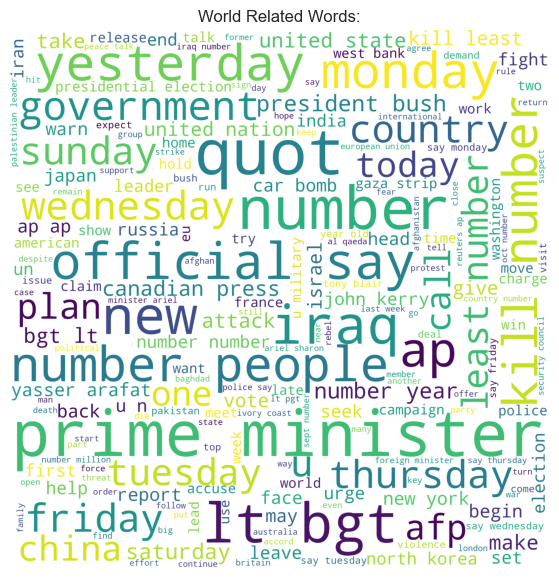

In [14]:
# Wordcloud Cizimi
visualize_WordCloud(df)
##########################################################################################################

In [15]:
#Dokuman ve unique kelime sayisi,
cv = CountVectorizer()
WC = cv.fit_transform(df['Text'])
print('There are {} documents in the training set.'.format(len(df)))
print('There are {} different words in the training set.'.format(WC.shape[1]))
##########################################################################################################

There are 120000 documents in the training set.
There are 56714 different words in the training set.


In [16]:
df.to_csv('modified_train2.csv', index=False)

In [17]:
###Model Kurma Aşaması###

In [18]:
#Model With F1-score
class Model_Acc():
    def __init__(self, f1, model):
        self.f1 = f1
        self.Model = model

#W2c için class yapısı
class Vectorizer(object):

    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array(
            [np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])


In [19]:
# Veri seti okunmasi
df = pd.read_csv('modified_train2.csv')

# Integer ciktisina gore kategori eslestirmek icin üolan dict degiskeni olusturuldu.
category = df[["Category", "CategoryID"]].drop_duplicates().sort_values('CategoryID')
category = dict(category[['CategoryID', 'Category']].values)  # Category Dictionary

print(list(category.values()))

['Business', 'Sci/Tech', 'Sports', 'World']


In [20]:
#Farklı vektörize işlemleri denendi ve en optimize çalışanı alındı.
x = np.array(df.Text.values)
y = np.array(df.CategoryID.values)
#Count Vectorizer
"""cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(df.Text).toarray()"""
#TF-IDF Vectorizer
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
x = tfidf.fit_transform(x)
#W2V
"""vec_model = Word2Vec(df['Text'], vector_size=400)
w2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.vectors))
vectorizer = Vectorizer(w2v)
x = vectorizer.transform(x)
x = minmax_scale(x, feature_range=(0, 1), axis=0, copy=True)"""

"vec_model = Word2Vec(df['Text'], vector_size=400)\nw2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.vectors))\nvectorizer = Vectorizer(w2v)\nx = vectorizer.transform(x)\nx = minmax_scale(x, feature_range=(0, 1), axis=0, copy=True)"

In [21]:
#Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
f1_list = []

In [22]:
#Grid search cv ile hiperparametre optimizasyonu yapıldı ve bu işlem uzun sürdüğünden bu kısım yorum satırına alındı.
"""# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=2)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = dict(n_estimators=n_estimators,
                   max_features=max_features,
                   bootstrap=bootstrap)

rfc_opt = GridSearchCV(rf, random_grid, cv=10)
rfc_opt.fit(x_train, y_train)

print('Best n_estimators: {}'.format(rfc_opt.best_estimator_.get_params()['n_estimators']))
print('Best max_features: ', rfc_opt.best_estimator_.get_params()['max_features'])
print('Best bootstrap: ', rfc_opt.best_estimator_.get_params()['bootstrap'])"""

"""Best n_estimators: 100
Best max_features:  sqrt
Best bootstrap:  True"""

'Best n_estimators: 100\nBest max_features:  sqrt\nBest bootstrap:  True'

-------LOGISTIC REGRESSION-------



              precision    recall  f1-score   support

    Business       0.86      0.87      0.86      8916
    Sci/Tech       0.87      0.87      0.87      8980
      Sports       0.96      0.93      0.95      9287
       World       0.89      0.91      0.90      8817

    accuracy                           0.89     36000
   macro avg       0.89      0.89      0.89     36000
weighted avg       0.89      0.89      0.89     36000



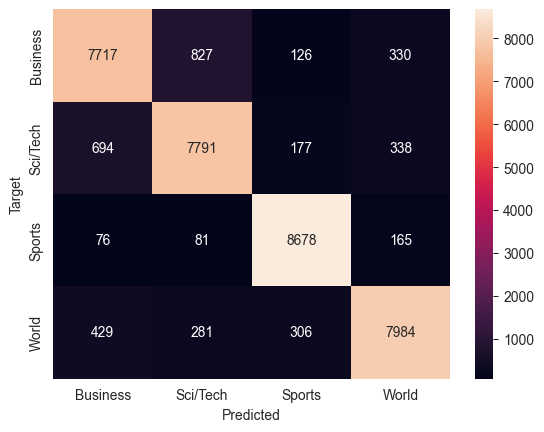

In [23]:

# Log Reg
print("-------LOGISTIC REGRESSION-------\n")

lg = LogisticRegression(
    fit_intercept=True,
    class_weight=None,
    max_iter=1000,
    random_state=42)

lg.fit(x_train, y_train)
y_pred = lg.predict(x_test)


f1 = f1_score(y_test, y_pred, average='macro')
f1_list.append(Model_Acc(f1, lg))

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm)
print("\n")
print(classification_report(y_pred, y_test, target_names=list(category.values())))
###############################################################################################

-------RANDOM FOREST CLASSIFIER-------


              precision    recall  f1-score   support

    Business       0.78      0.83      0.80      8454
    Sci/Tech       0.80      0.82      0.81      8821
      Sports       0.94      0.85      0.89     10016
       World       0.84      0.87      0.86      8709

    accuracy                           0.84     36000
   macro avg       0.84      0.84      0.84     36000
weighted avg       0.85      0.84      0.84     36000



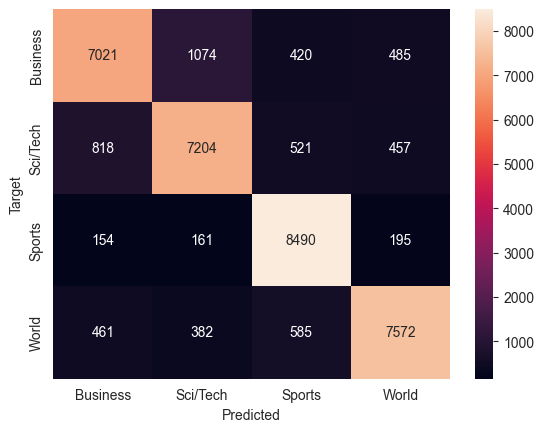

In [24]:
# Random Forest
print("-------RANDOM FOREST CLASSIFIER-------")
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0, bootstrap=True )

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

f1 = f1_score(y_test, y_pred, average='macro')
f1_list.append(Model_Acc(f1, rf))

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm)
print("\n")
print(classification_report(y_pred, y_test, target_names=list(category.values())))
###############################################################################################

-------MULTINOMIAL NAIVE BAYES-------
Confusion Matrix: 



              precision    recall  f1-score   support

    Business       0.81      0.85      0.82      8580
    Sci/Tech       0.84      0.83      0.83      9056
      Sports       0.96      0.89      0.92      9692
       World       0.86      0.89      0.87      8672

    accuracy                           0.86     36000
   macro avg       0.86      0.86      0.86     36000
weighted avg       0.87      0.86      0.86     36000



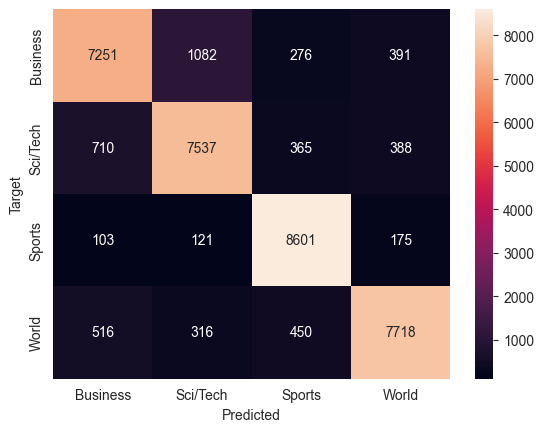

In [25]:
# Naive Bayes
print("-------MULTINOMIAL NAIVE BAYES-------")
mnb = MultinomialNB(alpha=0.5, fit_prior=False)
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)

f1 = f1_score(y_test, y_pred, average='macro')
f1_list.append(Model_Acc(f1, mnb))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n")
plot_cm(cm)
print("\n")
print(classification_report(y_pred, y_test, target_names=list(category.values())))
###############################################################################################

-------SUPPORT VECTOR MACHINE-------
Confusion Matrix: 



              precision    recall  f1-score   support

    Business       0.87      0.86      0.87      9058
    Sci/Tech       0.87      0.87      0.87      8984
      Sports       0.97      0.94      0.95      9237
       World       0.89      0.92      0.90      8721

    accuracy                           0.90     36000
   macro avg       0.90      0.90      0.90     36000
weighted avg       0.90      0.90      0.90     36000



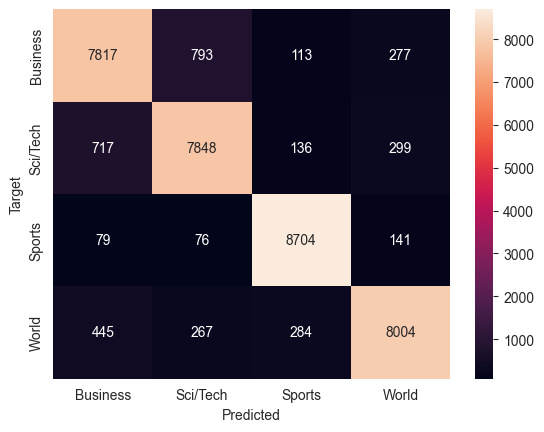

In [26]:
# SVC
print("-------SUPPORT VECTOR MACHINE-------")
svc = SVC(kernel="linear")
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)

f1 = f1_score(y_test, y_pred, average='macro')
f1_list.append(Model_Acc(f1, svc))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n")
plot_cm(cm)
print("\n")
print(classification_report(y_pred, y_test, target_names=list(category.values())))
###############################################################################################

-------DECISION TREE-------
Confusion Matrix: 



              precision    recall  f1-score   support

    Business       0.66      0.66      0.66      9079
    Sci/Tech       0.66      0.67      0.66      8907
      Sports       0.77      0.77      0.77      9009
       World       0.72      0.72      0.72      9005

    accuracy                           0.70     36000
   macro avg       0.70      0.70      0.70     36000
weighted avg       0.70      0.70      0.70     36000



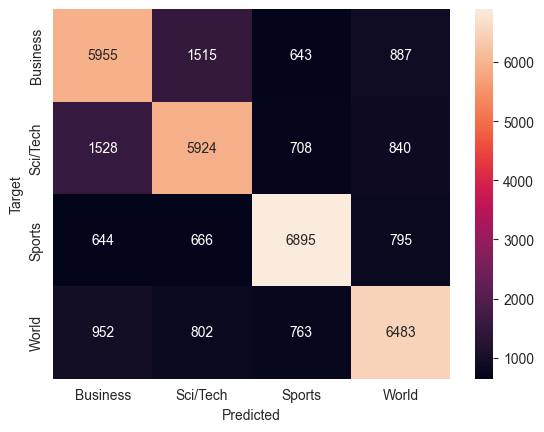

In [27]:
# Decision Tree
print("-------DECISION TREE-------")
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

f1 = f1_score(y_test, y_pred, average='macro')
f1_list.append(Model_Acc(f1, dt))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n")
plot_cm(cm)
print("\n")
print(classification_report(y_pred, y_test, target_names=list(category.values())))
###############################################################################################

-------KNN-------
Confusion Matrix: 



              precision    recall  f1-score   support

    Business       0.88      0.85      0.87      9307
    Sci/Tech       0.87      0.88      0.88      8873
      Sports       0.97      0.94      0.95      9243
       World       0.88      0.93      0.90      8577

    accuracy                           0.90     36000
   macro avg       0.90      0.90      0.90     36000
weighted avg       0.90      0.90      0.90     36000



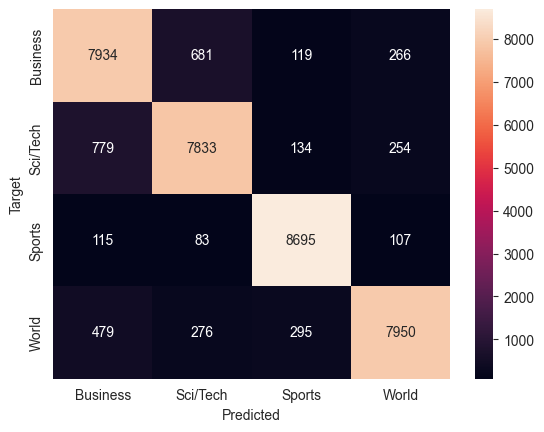

In [28]:
# K Neighbous Classifier
print("-------KNN-------")
knn = KNeighborsClassifier(algorithm='auto',
                     leaf_size=10,
                     metric='minkowski',
                     metric_params=None,
                     n_jobs=1,
                     n_neighbors=5,
                     p=2,
                     weights='uniform')
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)

f1 = f1_score(y_test, y_pred, average='macro')
f1_list.append(Model_Acc(f1,knn))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n")
plot_cm(cm)
print("\n")
print(classification_report(y_pred, y_test, target_names=list(category.values())))
###############################################################################################

In [29]:
import pickle
pickle.dump(f1_list, open('model_list.pkl', 'wb'))
#En iyi model üzerinden kullanıcı girişi alınması
max_f1 = 0
best_model = None
for m in f1_list:
    if m.f1 > max_f1:
        max_f1 = m.f1
        best_model = m.Model

print("The Model with the highest f1: " + type(best_model).__name__)


"""y_pred1 = tfidf.transform(['The Portuguese Football Federation (FPF) has denied reports that Cristiano Ronaldo '
                           'threatened to walk out on Portugal’s World Cup campaign. The 37-year-old started on the '
                           'bench for Tuesday’s last-16 win against Switzerland by Fernando Santos, having reacted '
                           'poorly to being substituted in the final group game against South Korea.Ronaldo came on '
                           'as a second-half substitute, but it was the first time since Euro 2008 that he has been '
                           'left out of a starting lineup at a major tournament, and he held talks with Santos on '
                           'Wednesday.'])"""

"""news = input("\n\nEnter the news that you want to learn its subject. \n")
y_pred1 = tfidf.transform([news])

yy = best_model.predict(y_pred1)
result = ""
if yy == [0]:
    result = "Business News"
elif yy == [1]:
    result = "Sci/Tech News"
elif yy == [2]:
    result = "Sports News"
elif yy == [3]:
    result = "World News"
print("Category result of test string: " + result)"""

The Model with the highest f1: KNeighborsClassifier


'news = input("\n\nEnter the news that you want to learn its subject. \n")\ny_pred1 = tfidf.transform([news])\n\nyy = best_model.predict(y_pred1)\nresult = ""\nif yy == [0]:\n    result = "Business News"\nelif yy == [1]:\n    result = "Entertainment News"\nelif yy == [2]:\n    result = "Politics News"\nelif yy == [3]:\n    result = "Sports News"\nelif yy == [4]:\n    result = "Tech News"\nprint("Category result of test string: " + result)'

In [30]:
import pickle
pickle.dump(f1_list, open('model_list.pkl', 'wb'))

In [32]:
pickled_model = pickle.load(open('model_list.pkl', 'rb'))

In [37]:
max_f1 = 0
best_model = None
for m in pickled_model:
    if m.f1 > max_f1:
        max_f1 = m.f1
        best_model = m.Model

print("The Model with the highest f1: " + type(best_model).__name__)


"""y_pred1 = tfidf.transform(['The Portuguese Football Federation (FPF) has denied reports that Cristiano Ronaldo '
                           'threatened to walk out on Portugal’s World Cup campaign. The 37-year-old started on the '
                           'bench for Tuesday’s last-16 win against Switzerland by Fernando Santos, having reacted '
                           'poorly to being substituted in the final group game against South Korea.Ronaldo came on '
                           'as a second-half substitute, but it was the first time since Euro 2008 that he has been '
                           'left out of a starting lineup at a major tournament, and he held talks with Santos on '
                           'Wednesday.'])"""

news = input("\n\nEnter the news that you want to learn its subject. \n")
y_pred1 = tfidf.transform([news])

yy = best_model.predict(y_pred1)
result = ""
if yy == [0]:
    result = "Business News"
elif yy == [1]:
    result = "Sci/Tech News"
elif yy == [2]:
    result = "Sports News"
elif yy == [3]:
    result = "World News"
print("Category result of test string: " + result)

The Model with the highest f1: KNeighborsClassifier
Category result of test string: World News
